**Import and install Required Libraries**

In [1]:
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# Import required libraries

import keras                                   # Deep learning library
import string                                  # Library for string constants and operations
import re                                      # Library for regular expressions
import pandas as pd                            # Library for data manipulation and analysis


from keras.models import Sequential            # Keras model type for creating models layer-by-layer
from numpy import array, argmax, random, take  # Library for multi-dimensional arrays and matrices
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed  # Keras layers for neural networks
from keras.callbacks import ModelCheckpoint   # Keras callback for saving the model after every epoch
from keras.preprocessing.text import Tokenizer # Keras class for text tokenization
from tensorflow.keras.preprocessing.sequence import pad_sequences # Keras function for padding sequences
from keras.models import load_model            # Keras function for loading a saved model
from keras import optimizers                   # Keras module for optimization algorithms

import matplotlib.pyplot as plt               # Library for creating data visualizations
#%matplotlib inline                             # Command for displaying plots inline in Jupyter notebooks
# Set option to display maximum column width in pandas
pd.set_option('display.max_colwidth', 200)


**Reading the Data**

We have a text file named deu.txt which has the Engilsg-German sentences pairs. We have to first read the file using the function defined below.

In [8]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now we will define a function to split this file into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences in order to view the Data we have

In [9]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

The data "deu.txt" in your working directory of the github

In [10]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The dataset we're working with contains over 150,000 sentence pairs, but for the purposes of reducing the training time of our model, we'll be using only the first 30,000 pairs. Feel free to adjust this number based on your system's computational power.

In [11]:
deu_eng = deu_eng[:30000,:]

**Start Pre-processing**

To clean the text we need to look at the data and then decide what approach should we take for pre-processing.

In [12]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["Aren't you worried?", 'Machen Sie sich keine Sorgen?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6091213 (CK) & #10301462 (Yorwba)'],
       ['Ask Tom to do that.', 'Bitten Sie Tom, das zu tun.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6233916 (CK) & #6645728 (Felixjp)'],
       ['Ask Tom to do this.', 'Bitten Sie Tom, das zu tun.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9070353 (CK) & #6645728 (Felixjp)']],
      dtype='<U537')

Removing all punctuation marks from the German and English sentences in the deu_eng array. It first selects the first column of the array which contains the German sentences using deu_eng[:,0], and applies the translate() method to remove all punctuation marks from each sentence. Similarly, it selects the second column of the array which contains the corresponding English sentences using deu_eng[:,1], and removes the punctuation marks from them as well. This is done to ensure that the model focuses on the language content of the sentences rather than the punctuation used.

In [13]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [14]:
deu_eng #Display

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Arent you worried', 'Machen Sie sich keine Sorgen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6091213 (CK) & #10301462 (Yorwba)'],
       ['Ask Tom to do that', 'Bitten Sie Tom das zu tun',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6233916 (CK) & #6645728 (Felixjp)'],
       ['Ask Tom to do this', 'Bitten Sie Tom das zu tun',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9070353 (CK) & #6645728 (Felixjp)']],
      dtype='<U537')

Converting all the sentences in the deu_eng array to lowercase. It iterates through each row in the array using a for loop and converts the source sentence (German) to lowercase using the lower() function and then assigns it back to the same position in the array. Similarly, it converts the target sentence (English) to lowercase and assigns it back to the same position in the array. This is done to ensure that the model does not treat the same words with different capitalizations as different words.

In [15]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [16]:
deu_eng #Display

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['arent you worried', 'machen sie sich keine sorgen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6091213 (CK) & #10301462 (Yorwba)'],
       ['ask tom to do that', 'bitten sie tom das zu tun',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #6233916 (CK) & #6645728 (Felixjp)'],
       ['ask tom to do this', 'bitten sie tom das zu tun',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9070353 (CK) & #6645728 (Felixjp)']],
      dtype='<U537')

**Text to Sequence Conversion**

In order to prepare our data for a Seq2Seq model, we need to convert both the input and output sentences into fixed-length integer sequences. But before we do that, let's visualize the length of the sentences. To do this, we'll create two separate lists - one for English sentences and one for German sentences - to capture the lengths of all the sentences in each language.

In [17]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [18]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

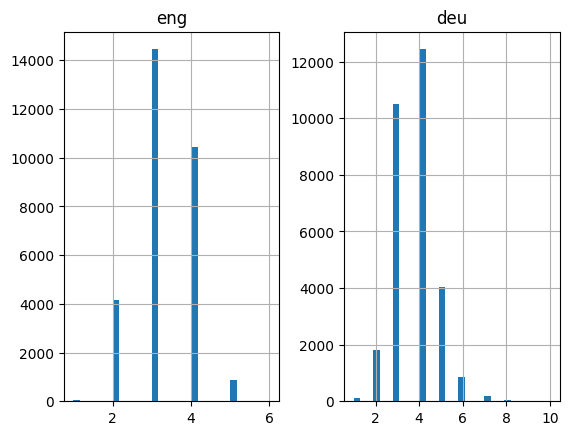

In [19]:
length_df.hist(bins = 30)
plt.show()

After visualizing the lengths of the German and English sentences, we found that the maximum length of German sentences is 11 and the maximum length of English phrases is 8.

To prepare our text data for modeling, we'll use Keras's Tokenizer() class to vectorize our sentences into sequences of integers. We'll then pad these sequences with zeros to make them all the same length, ensuring compatibility with our Seq2Seq model.

In [20]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [21]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4593


In [22]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 7290


Next, we have a function that prepares the sequences for modeling. This function will also perform padding to ensure all sequences have the same length, with the maximum length determined by the longest sentence in each language as mentioned earlier

In [23]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

**Model Building**

To train and evaluate our model, we'll now split our data into training and testing sets. We'll use the training set for model training and the testing set for model evaluation

In [24]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

Now, we'll proceed to encode our sentences. For the purposes of our Seq2Seq model, we'll encode the German sentences as the input sequences and the English sentences as the target sequences. We'll perform this encoding process for both our train and test datasets.

In [25]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [26]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Finally, it's time to define the architecture of our Seq2Seq model! For the encoder, we'll use an Embedding layer and an LSTM layer. For the decoder, we'll use another LSTM layer followed by a Dense layer. This architecture will enable us to effectively translate German sentences into English sentences.

In [27]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In this particular model, we'll be using the RMSprop optimizer. This is a popular choice for recurrent neural networks like ours, as it has been shown to work well for this type of architecture

In [28]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


This code is training the model using the training data, with the aim of minimizing the loss function (sparse categorical crossentropy). It does this over 30 epochs, using a batch size of 512. It also saves the best model according to the validation loss metric to a file named 'model.filetocheck'.

In [29]:
filename = 'model.filetocheck'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
38/38 [==============================] - ETA: 0s - loss: 3.3431
Epoch 1: val_loss improved from inf to 2.58782, saving model to model.filetocheck


38/38 [==============================] - 121s 3s/step - loss: 3.3431 - val_loss: 2.5878
Epoch 2/30
38/38 [==============================] - ETA: 0s - loss: 2.4701
Epoch 2: val_loss improved from 2.58782 to 2.45819, saving model to model.filetocheck


38/38 [==============================] - 119s 3s/step - loss: 2.4701 - val_loss: 2.4582
Epoch 3/30
38/38 [==============================] - ETA: 0s - loss: 2.3731
Epoch 3: val_loss improved from 2.45819 to 2.38281, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 2.3731 - val_loss: 2.3828
Epoch 4/30
38/38 [==============================] - ETA: 0s - loss: 2.2853
Epoch 4: val_loss improved from 2.38281 to 2.29675, saving model to model.filetocheck


38/38 [==============================] - 117s 3s/step - loss: 2.2853 - val_loss: 2.2968
Epoch 5/30
38/38 [==============================] - ETA: 0s - loss: 2.1547
Epoch 5: val_loss improved from 2.29675 to 2.17498, saving model to model.filetocheck


38/38 [==============================] - 116s 3s/step - loss: 2.1547 - val_loss: 2.1750
Epoch 6/30
38/38 [==============================] - ETA: 0s - loss: 2.0335
Epoch 6: val_loss improved from 2.17498 to 2.08996, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 2.0335 - val_loss: 2.0900
Epoch 7/30
38/38 [==============================] - ETA: 0s - loss: 1.9351
Epoch 7: val_loss improved from 2.08996 to 2.06253, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 1.9351 - val_loss: 2.0625
Epoch 8/30
38/38 [==============================] - ETA: 0s - loss: 1.8481
Epoch 8: val_loss improved from 2.06253 to 2.00462, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 1.8481 - val_loss: 2.0046
Epoch 9/30
38/38 [==============================] - ETA: 0s - loss: 1.7622
Epoch 9: val_loss improved from 2.00462 to 1.92456, saving model to model.filetocheck


38/38 [==============================] - 117s 3s/step - loss: 1.7622 - val_loss: 1.9246
Epoch 10/30
38/38 [==============================] - ETA: 0s - loss: 1.6784
Epoch 10: val_loss improved from 1.92456 to 1.89806, saving model to model.filetocheck


38/38 [==============================] - 120s 3s/step - loss: 1.6784 - val_loss: 1.8981
Epoch 11/30
38/38 [==============================] - ETA: 0s - loss: 1.6055
Epoch 11: val_loss improved from 1.89806 to 1.81867, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 1.6055 - val_loss: 1.8187
Epoch 12/30
38/38 [==============================] - ETA: 0s - loss: 1.5320
Epoch 12: val_loss improved from 1.81867 to 1.76890, saving model to model.filetocheck


38/38 [==============================] - 117s 3s/step - loss: 1.5320 - val_loss: 1.7689
Epoch 13/30
38/38 [==============================] - ETA: 0s - loss: 1.4618
Epoch 13: val_loss improved from 1.76890 to 1.72994, saving model to model.filetocheck


38/38 [==============================] - 117s 3s/step - loss: 1.4618 - val_loss: 1.7299
Epoch 14/30
38/38 [==============================] - ETA: 0s - loss: 1.3950
Epoch 14: val_loss improved from 1.72994 to 1.70557, saving model to model.filetocheck


38/38 [==============================] - 121s 3s/step - loss: 1.3950 - val_loss: 1.7056
Epoch 15/30
38/38 [==============================] - ETA: 0s - loss: 1.3308
Epoch 15: val_loss improved from 1.70557 to 1.67233, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 1.3308 - val_loss: 1.6723
Epoch 16/30
38/38 [==============================] - ETA: 0s - loss: 1.2715
Epoch 16: val_loss improved from 1.67233 to 1.62161, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 1.2715 - val_loss: 1.6216
Epoch 17/30
38/38 [==============================] - ETA: 0s - loss: 1.2115
Epoch 17: val_loss improved from 1.62161 to 1.59260, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 1.2115 - val_loss: 1.5926
Epoch 18/30
38/38 [==============================] - ETA: 0s - loss: 1.1538
Epoch 18: val_loss improved from 1.59260 to 1.57313, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 1.1538 - val_loss: 1.5731
Epoch 19/30
38/38 [==============================] - ETA: 0s - loss: 1.0986
Epoch 19: val_loss improved from 1.57313 to 1.55740, saving model to model.filetocheck


38/38 [==============================] - 121s 3s/step - loss: 1.0986 - val_loss: 1.5574
Epoch 20/30
38/38 [==============================] - ETA: 0s - loss: 1.0454
Epoch 20: val_loss improved from 1.55740 to 1.51862, saving model to model.filetocheck


38/38 [==============================] - 116s 3s/step - loss: 1.0454 - val_loss: 1.5186
Epoch 21/30
38/38 [==============================] - ETA: 0s - loss: 0.9916
Epoch 21: val_loss improved from 1.51862 to 1.48781, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 0.9916 - val_loss: 1.4878
Epoch 22/30
38/38 [==============================] - ETA: 0s - loss: 0.9411
Epoch 22: val_loss did not improve from 1.48781
38/38 [==============================] - 105s 3s/step - loss: 0.9411 - val_loss: 1.4965
Epoch 23/30
38/38 [==============================] - ETA: 0s - loss: 0.8919
Epoch 23: val_loss improved from 1.48781 to 1.46763, saving model to model.filetocheck


38/38 [==============================] - 117s 3s/step - loss: 0.8919 - val_loss: 1.4676
Epoch 24/30
38/38 [==============================] - ETA: 0s - loss: 0.8451
Epoch 24: val_loss improved from 1.46763 to 1.43971, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 0.8451 - val_loss: 1.4397
Epoch 25/30
38/38 [==============================] - ETA: 0s - loss: 0.7980
Epoch 25: val_loss improved from 1.43971 to 1.42165, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 0.7980 - val_loss: 1.4216
Epoch 26/30
38/38 [==============================] - ETA: 0s - loss: 0.7531
Epoch 26: val_loss improved from 1.42165 to 1.41596, saving model to model.filetocheck


38/38 [==============================] - 117s 3s/step - loss: 0.7531 - val_loss: 1.4160
Epoch 27/30
38/38 [==============================] - ETA: 0s - loss: 0.7092
Epoch 27: val_loss improved from 1.41596 to 1.37947, saving model to model.filetocheck


38/38 [==============================] - 117s 3s/step - loss: 0.7092 - val_loss: 1.3795
Epoch 28/30
38/38 [==============================] - ETA: 0s - loss: 0.6689
Epoch 28: val_loss improved from 1.37947 to 1.36529, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 0.6689 - val_loss: 1.3653
Epoch 29/30
38/38 [==============================] - ETA: 0s - loss: 0.6268
Epoch 29: val_loss improved from 1.36529 to 1.35250, saving model to model.filetocheck


38/38 [==============================] - 118s 3s/step - loss: 0.6268 - val_loss: 1.3525
Epoch 30/30
38/38 [==============================] - ETA: 0s - loss: 0.5857
Epoch 30: val_loss did not improve from 1.35250
38/38 [==============================] - 107s 3s/step - loss: 0.5857 - val_loss: 1.3574


Comparing the training loss and the validation loss.

And display a plot of the training loss and validation loss over the epochs of training.

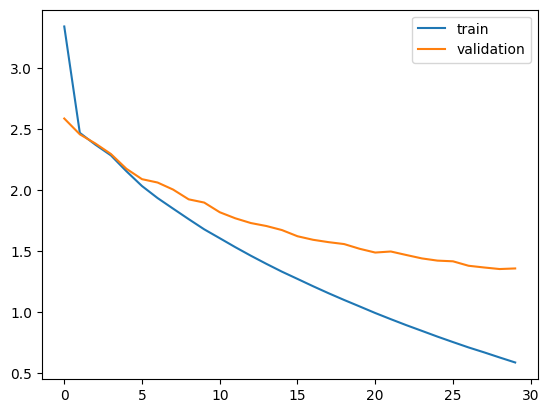

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

**Make Predictions**

Let's load the saved model to make predictions.

In [31]:
model = load_model('model.filetocheck')
preds = model.predict(testX.reshape((testX.shape[0],testX.shape[1])))
preds_classes = preds.argmax(axis=-1)


188/188 [==============================] - 15s 73ms/step


In [32]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [33]:
# convert predictions into text (English)
import numpy as np

preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(np.argmax(i[j]), eng_tokenizer)
        if j > 0:
            if (t == get_word(np.argmax(i[j-1]), eng_tokenizer)) or (t is None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t is None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))


In [34]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [35]:
pd.set_option('display.max_colwidth', 200)

In [36]:
pred_df.head(15)

,actual,predicted
0,theyre in love,they are kind
1,theyre all bad,theyre all busy
2,tom is naughty,tom is relieved
3,how rich is tom,how tom
4,wont you sing,cant you know
5,i saw that,i saw that
6,theyre drenched,theyre are
7,tom felt terrific,tom felt sleepy
8,they were naive,they were friends
9,give it a go,show it a


In [37]:
pred_df.tail(15)

,actual,predicted
5985,tom wasnt eating,tom didnt ate
5986,come on wake up,come on up
5987,i agreed with her,i hate you
5988,ill go ask tom,ill will tom
5989,he is at his desk,hes my liar
5990,they arent there,theyre arent here
5991,the money is gone,the crowd is
5992,i cant help it,i can help
5993,tom says hello,tom will you
5994,tom came to watch,tom came at


In [38]:
pred_df.sample(15)

,actual,predicted
1713,im bluffing,i eating
2588,give us a break,take a
4468,i bet it was tom,i saw tom
5538,they appear dead,you seem busy
4589,it was a cold day,it was a idea day
4550,call your brother,wash your feet
5335,is it damaged,is he
5563,work slowly,it was
5679,i know i did that,i know i know
5495,tom loves reading,tom loves to
